In [5]:
%load_ext autoreload
%autoreload 2

import importlib
import cv2
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def convert_y_label_to_string(y, dataset=dataset):
    return ''.join([dataset.mapper(int(i)) for i in y])

In [6]:
from text_recognizer.models import VisionTransformerModel
from text_recognizer.datasets import IamLinesDataset
from text_recognizer.datasets.transforms import Compose, AddTokens

In [80]:
target_transform = Compose([torch.tensor, AddTokens(init_token="<sos>", eos_token="<eos>")])
dataset = IamLinesDataset(train=True, init_token="<sos>", pad_token="_", eos_token="<eos>", target_transform=target_transform)
dataset.load_or_generate_data()

In [55]:
config_path = "../training/experiments/VisionTransformerModel_IamLinesDataset_VisionTransformer/1021_083538/config.yml"
with open(config_path, "r") as f:
    experiment_config = yaml.safe_load(f)

In [10]:
dataset_args = experiment_config.get("dataset", {})
datasets_module = importlib.import_module("text_recognizer.datasets")
dataset_ = getattr(datasets_module, dataset_args["type"])

network_module = importlib.import_module("text_recognizer.networks")
network_fn_ = getattr(network_module, experiment_config["network"]["type"])

In [24]:
model = VisionTransformerModel(network_fn=network_fn_, dataset=dataset_, dataset_args=dataset_args)

2020-10-21 23:27:40.719 | DEBUG    | text_recognizer.models.base:load_weights:454 - Loading network with pretrained weights.


In [28]:
checkpoint_path = "../training/experiments/VisionTransformerModel_IamLinesDataset_VisionTransformer/1021_083538/model/last.pt"
model.load_from_checkpoint(checkpoint_path)

2020-10-21 23:29:55.892 | DEBUG    | text_recognizer.models.base:load_from_checkpoint:402 - Loading checkpoint...


In [40]:
model.eval()

In [90]:
data, target = dataset[18]
sentence = convert_y_label_to_string(target, dataset) 

([], [])

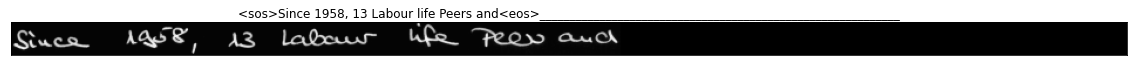

In [91]:
plt.figure(figsize=(20, 20))
plt.title(sentence)
plt.imshow(data.squeeze(0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

In [92]:
model.predict_on_image(data)

('Since 1958, 13 Labour life Peers and<eos>', 0.9999997615814209)

In [95]:
experiment_config["train_args"]["input_shape"]

[[1, 28, 952], [92]]

In [99]:
model.summary(experiment_config["train_args"]["input_shape"], 4)

Layer (type:depth-idx)                                  Output Shape              Param #
├─Sequential: 1-1                                       [-1, 158, 1, 28, 6]       --
|    └─Unfold: 2-1                                      [-1, 168, 158]            --
|    └─Rearrange: 2-2                                   [-1, 158, 1, 28, 6]       --
├─Linear: 1-2                                           [-1, 158, 512]            86,528
├─PositionalEncoding: 1-3                               [-1, 158, 512]            --
|    └─Dropout: 2-3                                     [-1, 158, 512]            --
├─Embedding: 1-4                                        [-1, 92, 512]             41,984
├─PositionalEncoding: 1-5                               [-1, 92, 512]             --
|    └─Dropout: 2-4                                     [-1, 92, 512]             --
├─Transformer: 1-6                                      [-1, 92, 512]             --
|    └─Encoder: 2-5                                 